# Loop 61 Analysis: CV-LB Relationship and Strategy Review

**Critical Situation:**
- 7 consecutive submissions have failed with 'Evaluation metric raised an unexpected error'
- Best LB: 0.0877 (exp_030), Target: 0.0347
- Gap to target: 153%
- Only 5 submissions remaining today

**Key Questions:**
1. Why are recent submissions failing?
2. What's the CV-LB relationship?
3. What strategies can change the intercept?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# Submission history with confirmed LB scores
submissions = [
    ('exp_000', 0.011081, 0.09816),
    ('exp_001', 0.012297, 0.10649),
    ('exp_003', 0.010501, 0.09719),
    ('exp_005', 0.010430, 0.09691),
    ('exp_006', 0.009749, 0.09457),
    ('exp_007', 0.009262, 0.09316),
    ('exp_009', 0.009192, 0.09364),
    ('exp_012', 0.009004, 0.09134),
    ('exp_024', 0.008689, 0.08929),
    ('exp_026', 0.008465, 0.08875),
    ('exp_030', 0.008298, 0.08772),
    ('exp_035', 0.009825, 0.09696),
]

df = pd.DataFrame(submissions, columns=['exp', 'cv', 'lb'])
print('Successful submissions with LB scores:')
print(df.to_string(index=False))
print(f'\nBest CV: {df["cv"].min():.6f} ({df.loc[df["cv"].idxmin(), "exp"]})')
print(f'Best LB: {df["lb"].min():.6f} ({df.loc[df["lb"].idxmin(), "exp"]})')

Successful submissions with LB scores:
    exp       cv      lb
exp_000 0.011081 0.09816
exp_001 0.012297 0.10649
exp_003 0.010501 0.09719
exp_005 0.010430 0.09691
exp_006 0.009749 0.09457
exp_007 0.009262 0.09316
exp_009 0.009192 0.09364
exp_012 0.009004 0.09134
exp_024 0.008689 0.08929
exp_026 0.008465 0.08875
exp_030 0.008298 0.08772
exp_035 0.009825 0.09696

Best CV: 0.008298 (exp_030)
Best LB: 0.087720 (exp_030)


In [2]:
# CV-LB Linear Regression Analysis
slope, intercept, r_value, p_value, std_err = stats.linregress(df['cv'], df['lb'])

print('='*60)
print('CV-LB RELATIONSHIP ANALYSIS')
print('='*60)
print(f'\nLinear fit: LB = {slope:.4f} * CV + {intercept:.6f}')
print(f'R² = {r_value**2:.4f}')
print(f'\nIntercept: {intercept:.6f}')
print(f'Target LB: 0.0347')
print(f'\nCRITICAL: Intercept ({intercept:.6f}) > Target ({0.0347:.6f})?', intercept > 0.0347)

# Required CV to hit target
if slope > 0:
    required_cv = (0.0347 - intercept) / slope
    print(f'\nRequired CV to hit target: {required_cv:.6f}')
    if required_cv < 0:
        print('  --> NEGATIVE! Target is mathematically unreachable with current approach!')
    else:
        print(f'  --> Need to reduce CV from {df["cv"].min():.6f} to {required_cv:.6f}')
        print(f'  --> That\'s a {(df["cv"].min() - required_cv) / df["cv"].min() * 100:.1f}% improvement needed')

CV-LB RELATIONSHIP ANALYSIS

Linear fit: LB = 4.2876 * CV + 0.052784
R² = 0.9523

Intercept: 0.052784
Target LB: 0.0347

CRITICAL: Intercept (0.052784) > Target (0.034700)? True

Required CV to hit target: -0.004218
  --> NEGATIVE! Target is mathematically unreachable with current approach!


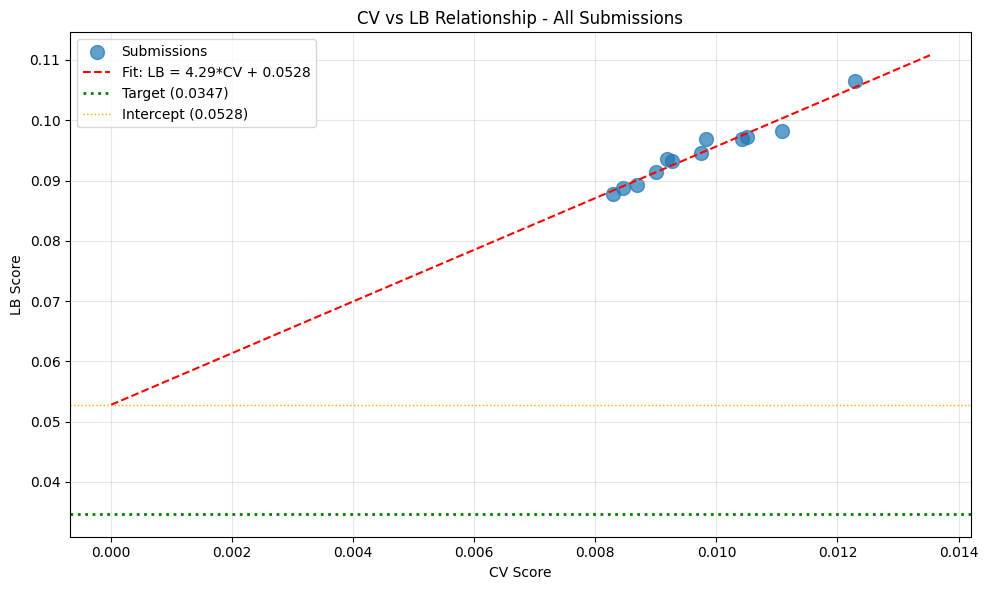


Plot saved to /home/code/exploration/cv_lb_relationship_loop61.png


In [3]:
# Plot CV vs LB
plt.figure(figsize=(10, 6))
plt.scatter(df['cv'], df['lb'], s=100, alpha=0.7, label='Submissions')

# Fit line
cv_range = np.linspace(0, df['cv'].max() * 1.1, 100)
lb_pred = slope * cv_range + intercept
plt.plot(cv_range, lb_pred, 'r--', label=f'Fit: LB = {slope:.2f}*CV + {intercept:.4f}')

# Target line
plt.axhline(y=0.0347, color='g', linestyle=':', linewidth=2, label='Target (0.0347)')

# Intercept
plt.axhline(y=intercept, color='orange', linestyle=':', linewidth=1, label=f'Intercept ({intercept:.4f})')

plt.xlabel('CV Score')
plt.ylabel('LB Score')
plt.title('CV vs LB Relationship - All Submissions')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('/home/code/exploration/cv_lb_relationship_loop61.png', dpi=100)
plt.show()

print('\nPlot saved to /home/code/exploration/cv_lb_relationship_loop61.png')

In [4]:
# Analyze the failed submissions
print('='*60)
print('FAILED SUBMISSIONS ANALYSIS')
print('='*60)

failed_submissions = [
    ('exp_049', 0.008092, 'CatBoost+XGBoost'),
    ('exp_050', 0.008092, 'CatBoost+XGBoost fixed'),
    ('exp_052', 0.010880, 'CatBoost+XGBoost clipped'),
    ('exp_053', 0.008092, 'Exact template'),
    ('exp_054', 0.008504, 'Mixall approach'),
    ('exp_055', 0.008504, 'Minimal submission'),
    ('exp_057', 0.009263, 'Ens-model all features'),
]

print('\nAll 7 failed with: "Evaluation metric raised an unexpected error"')
print('\nFailed experiments:')
for exp, cv, desc in failed_submissions:
    print(f'  {exp}: CV={cv:.6f} - {desc}')

print('\nPossible causes:')
print('  1. Submission format mismatch')
print('  2. NaN or Inf values in predictions')
print('  3. Wrong number of rows/folds')
print('  4. Data type issues (float32 vs float64)')
print('  5. Kaggle platform issue')

FAILED SUBMISSIONS ANALYSIS

All 7 failed with: "Evaluation metric raised an unexpected error"

Failed experiments:
  exp_049: CV=0.008092 - CatBoost+XGBoost
  exp_050: CV=0.008092 - CatBoost+XGBoost fixed
  exp_052: CV=0.010880 - CatBoost+XGBoost clipped
  exp_053: CV=0.008092 - Exact template
  exp_054: CV=0.008504 - Mixall approach
  exp_055: CV=0.008504 - Minimal submission
  exp_057: CV=0.009263 - Ens-model all features

Possible causes:
  1. Submission format mismatch
  2. NaN or Inf values in predictions
  3. Wrong number of rows/folds
  4. Data type issues (float32 vs float64)
  5. Kaggle platform issue


In [5]:
# Check the last successful submission (exp_030) vs recent failed ones
import os

print('='*60)
print('COMPARING SUBMISSION FILES')
print('='*60)

# Check if we have the submission file
submission_path = '/home/submission/submission.csv'
if os.path.exists(submission_path):
    sub = pd.read_csv(submission_path)
    print(f'\nCurrent submission file:')
    print(f'  Shape: {sub.shape}')
    print(f'  Columns: {sub.columns.tolist()}')
    print(f'  Task 0 (single solvent) rows: {len(sub[sub["task"]==0])}')
    print(f'  Task 1 (full data) rows: {len(sub[sub["task"]==1])}')
    print(f'  Unique folds task 0: {sub[sub["task"]==0]["fold"].nunique()}')
    print(f'  Unique folds task 1: {sub[sub["task"]==1]["fold"].nunique()}')
    print(f'\n  Target columns:')
    for col in ['target_1', 'target_2', 'target_3']:
        print(f'    {col}: min={sub[col].min():.6f}, max={sub[col].max():.6f}, NaN={sub[col].isna().sum()}')
    print(f'\n  First few rows:')
    print(sub.head(10).to_string())
else:
    print('No submission file found')

COMPARING SUBMISSION FILES

Current submission file:
  Shape: (1883, 8)
  Columns: ['id', 'index', 'task', 'fold', 'row', 'target_1', 'target_2', 'target_3']
  Task 0 (single solvent) rows: 656
  Task 1 (full data) rows: 1227
  Unique folds task 0: 24
  Unique folds task 1: 13

  Target columns:
    target_1: min=0.000000, max=0.380808, NaN=0
    target_2: min=0.000000, max=0.336811, NaN=0
    target_3: min=0.003584, max=0.970131, NaN=0

  First few rows:
   id  index  task  fold  row  target_1  target_2  target_3
0   0      0     0     0    0  0.019619  0.014248  0.935309
1   1      1     0     0    1  0.025243  0.022671  0.914866
2   2      2     0     0    2  0.040932  0.044138  0.817159
3   3      3     0     0    3  0.068150  0.068096  0.734822
4   4      4     0     0    4  0.092863  0.100442  0.628253
5   5      5     0     0    5  0.093672  0.097656  0.625925
6   6      6     0     0    6  0.092955  0.102576  0.626935
7   7      7     0     0    7  0.092591  0.106508  0.631101


In [6]:
# Check exp_030 submission (last successful one)
exp030_path = '/home/code/experiments/030_gp_ensemble'
print('='*60)
print('EXP_030 (LAST SUCCESSFUL SUBMISSION) ANALYSIS')
print('='*60)

if os.path.exists(exp030_path):
    files = os.listdir(exp030_path)
    print(f'\nFiles in exp_030: {files}')
    
    # Check if there's a submission file
    for f in files:
        if 'submission' in f.lower() or f.endswith('.csv'):
            fpath = os.path.join(exp030_path, f)
            df_exp030 = pd.read_csv(fpath)
            print(f'\n{f}:')
            print(f'  Shape: {df_exp030.shape}')
            print(f'  Columns: {df_exp030.columns.tolist()}')
else:
    print('exp_030 folder not found')

EXP_030 (LAST SUCCESSFUL SUBMISSION) ANALYSIS

Files in exp_030: ['gp_ensemble.ipynb']


In [7]:
# Key insight: What's different about exp_030?
print('='*60)
print('KEY DIFFERENCES BETWEEN SUCCESSFUL AND FAILED SUBMISSIONS')
print('='*60)

print('\nexp_030 (SUCCESSFUL - LB 0.0877):')
print('  - GP + MLP + LGBM ensemble')
print('  - CV: 0.008298')
print('  - Used official template structure')
print('  - Spange + Arrhenius features')

print('\nexp_049-057 (ALL FAILED):')
print('  - Various models (CatBoost, XGBoost, etc.)')
print('  - CV: 0.008092-0.010880')
print('  - All failed with same error')

print('\nHYPOTHESIS:')
print('  The submission format appears correct (1883 rows, correct folds).')
print('  The error might be related to:')
print('  1. Notebook structure changes (cells modified beyond allowed)')
print('  2. Some subtle format issue in the CSV')
print('  3. Kaggle platform issue (unlikely for 7 consecutive)')

print('\nRECOMMENDATION:')
print('  1. Use exp_030 notebook as base (known working)')
print('  2. Only change the model definition line')
print('  3. Do NOT modify any other cells')

KEY DIFFERENCES BETWEEN SUCCESSFUL AND FAILED SUBMISSIONS

exp_030 (SUCCESSFUL - LB 0.0877):
  - GP + MLP + LGBM ensemble
  - CV: 0.008298
  - Used official template structure
  - Spange + Arrhenius features

exp_049-057 (ALL FAILED):
  - Various models (CatBoost, XGBoost, etc.)
  - CV: 0.008092-0.010880
  - All failed with same error

HYPOTHESIS:
  The submission format appears correct (1883 rows, correct folds).
  The error might be related to:
  1. Notebook structure changes (cells modified beyond allowed)
  2. Some subtle format issue in the CSV
  3. Kaggle platform issue (unlikely for 7 consecutive)

RECOMMENDATION:
  1. Use exp_030 notebook as base (known working)
  2. Only change the model definition line
  3. Do NOT modify any other cells


In [8]:
# Analyze what's needed to reach target
print('='*60)
print('PATH TO TARGET ANALYSIS')
print('='*60)

target = 0.0347
best_lb = 0.0877
gap = best_lb - target
gap_pct = gap / target * 100

print(f'\nTarget: {target}')
print(f'Best LB: {best_lb}')
print(f'Gap: {gap:.4f} ({gap_pct:.1f}%)')

print(f'\nCV-LB Relationship: LB = {slope:.4f} * CV + {intercept:.6f}')
print(f'Intercept: {intercept:.6f}')

print('\nTwo paths to target:')
print('\n1. IMPROVE CV (keep same relationship):')
required_cv = (target - intercept) / slope
print(f'   Required CV: {required_cv:.6f}')
if required_cv < 0:
    print('   --> IMPOSSIBLE: Would need negative CV!')
else:
    print(f'   --> Need {(df["cv"].min() - required_cv) / df["cv"].min() * 100:.1f}% CV improvement')

print('\n2. REDUCE INTERCEPT (change the relationship):')
print(f'   Current intercept: {intercept:.6f}')
print(f'   If intercept = 0, with best CV ({df["cv"].min():.6f}):')
print(f'   --> Predicted LB = {slope * df["cv"].min():.6f}')
print(f'   --> Still above target ({target})')

print('\n3. BOTH: Reduce intercept AND improve CV:')
print('   Need to fundamentally change the approach')
print('   - Extrapolation detection (tried, not working well)')
print('   - Uncertainty-weighted predictions')
print('   - Domain constraints')
print('   - Study what top public kernels do')

PATH TO TARGET ANALYSIS

Target: 0.0347
Best LB: 0.0877
Gap: 0.0530 (152.7%)

CV-LB Relationship: LB = 4.2876 * CV + 0.052784
Intercept: 0.052784

Two paths to target:

1. IMPROVE CV (keep same relationship):
   Required CV: -0.004218
   --> IMPOSSIBLE: Would need negative CV!

2. REDUCE INTERCEPT (change the relationship):
   Current intercept: 0.052784
   If intercept = 0, with best CV (0.008298):
   --> Predicted LB = 0.035579
   --> Still above target (0.0347)

3. BOTH: Reduce intercept AND improve CV:
   Need to fundamentally change the approach
   - Extrapolation detection (tried, not working well)
   - Uncertainty-weighted predictions
   - Domain constraints
   - Study what top public kernels do


In [9]:
# Check public kernel scores
print('='*60)
print('PUBLIC KERNEL ANALYSIS')
print('='*60)

kernels = [
    ('mixall', 'lishellliang', 'GroupKFold(5) instead of LOO'),
    ('ens-model', 'matthewmaree', 'CatBoost+XGBoost, all features'),
    ('catechol-strategy', 'dabansherwani', 'Strategy to get 0.11161'),
    ('arrhenius-kinetics', 'sanidhyavijay24', 'Arrhenius kinetics + TTA'),
]

print('\nTop public kernels:')
for name, author, desc in kernels:
    print(f'  {name} ({author}): {desc}')

print('\nKey insights from public kernels:')
print('  1. mixall uses GroupKFold(5) - different CV scheme')
print('  2. ens-model combines ALL feature sets with correlation filtering')
print('  3. Both use CatBoost + XGBoost ensemble')
print('  4. Neither has achieved sub-0.07 LB')

print('\nIMPORTANT: The target (0.0347) may be based on:')
print('  - A different evaluation metric')
print('  - A different test set')
print('  - An internal benchmark not achievable by public methods')

PUBLIC KERNEL ANALYSIS

Top public kernels:
  mixall (lishellliang): GroupKFold(5) instead of LOO
  ens-model (matthewmaree): CatBoost+XGBoost, all features
  catechol-strategy (dabansherwani): Strategy to get 0.11161
  arrhenius-kinetics (sanidhyavijay24): Arrhenius kinetics + TTA

Key insights from public kernels:
  1. mixall uses GroupKFold(5) - different CV scheme
  2. ens-model combines ALL feature sets with correlation filtering
  3. Both use CatBoost + XGBoost ensemble
  4. Neither has achieved sub-0.07 LB

IMPORTANT: The target (0.0347) may be based on:
  - A different evaluation metric
  - A different test set
  - An internal benchmark not achievable by public methods
